In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')

In [4]:
df.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [5]:
df.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [6]:
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
df.shape

(416809, 2)

In [8]:
df.duplicated().sum()

686

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().sum()

0

In [11]:
# we need to map the data so we can get the good visualization
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
    # Add more mappings as needed
}

df['label'] = df['label'].map(emotion_map)

<Axes: xlabel='label', ylabel='count'>

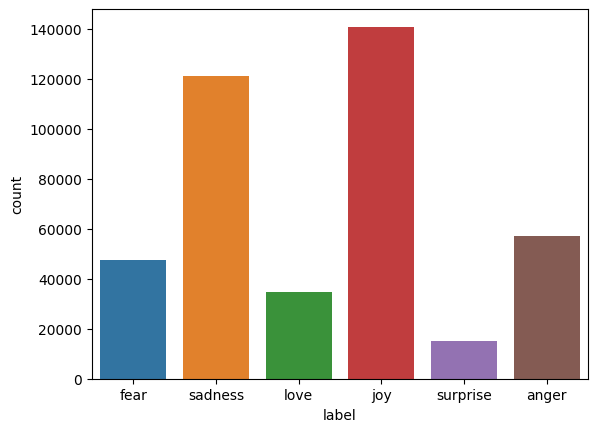

In [12]:
sns.countplot(data=df,x='label')

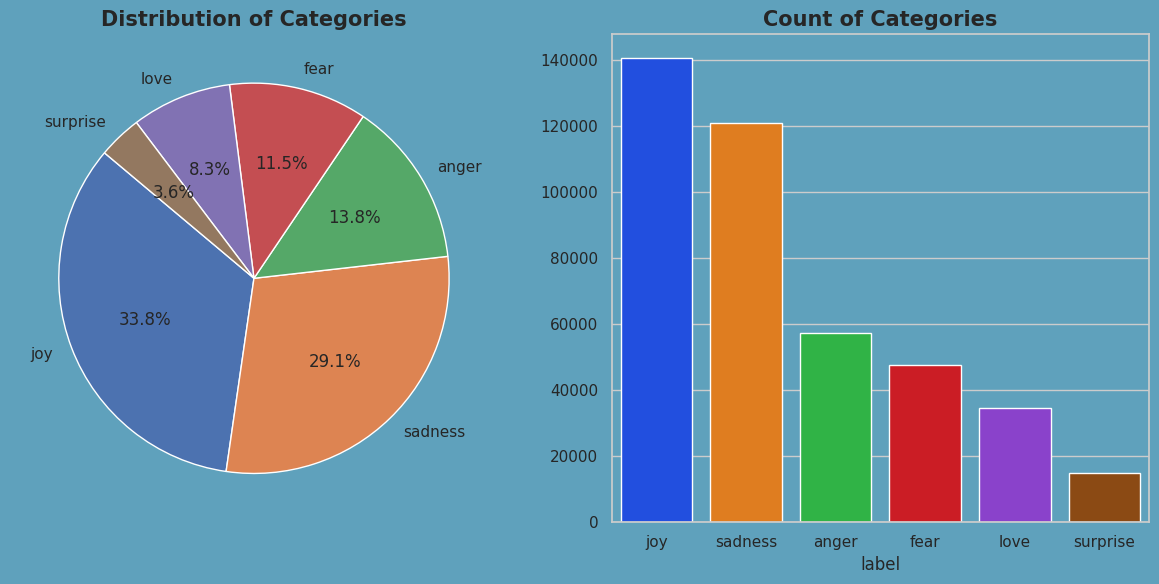

In [13]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [15]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text    label
0      i just feel really helpless and heavy hearted     fear
1  ive enjoyed being able to slouch about relax a...  sadness
2  i gave up my internship with the dmrg and am f...     fear
3                         i dont know i feel so lost  sadness
4  i am a kindergarten teacher and i am thoroughl...     fear


In [16]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [17]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0      i just feel really helpless and heavy hearted     fear
1  ive enjoyed being able to slouch about relax a...  sadness
2  i gave up my internship with the dmrg and am f...     fear
3                         i dont know i feel so lost  sadness
4  i am a kindergarten teacher and i am thoroughl...     fear


In [18]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0      i just feel really helpless and heavy hearted     fear
1  ive enjoyed being able to slouch about relax a...  sadness
2  i gave up my internship with the dmrg and am f...     fear
3                         i dont know i feel so lost  sadness
4  i am a kindergarten teacher and i am thoroughl...     fear


In [19]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text    label
0      i just feel really helpless and heavy hearted     fear
1  ive enjoyed being able to slouch about relax a...  sadness
2  i gave up my internship with the dmrg and am f...     fear
3                         i dont know i feel so lost  sadness
4  i am a kindergarten teacher and i am thoroughl...     fear


In [20]:
tqdm.pandas()

import emoji
df['text'] = df['text'].progress_apply(emoji.demojize)
df.head()

100%|██████████| 416123/416123 [00:31<00:00, 13146.44it/s]


,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [21]:
import string
exclude=string.punctuation
exclude

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
def remove_punc(text):
    for char in exclude:
        text=text.replace(char,'')
    return text

df['text']=df['text'].progress_apply(lambda x : remove_punc(x))
df.head()

100%|██████████| 416123/416123 [00:01<00:00, 232214.73it/s]


,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
StopWords = stopwords.words("english")
StopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
def remove_stopwords(text):
    filtered_text = ' '.join(word for word in text.split() if word.lower() not in StopWords)
    return filtered_text

df['text']=df['text'].progress_apply(lambda x : remove_stopwords(x))
df.head()

100%|██████████| 416123/416123 [00:13<00:00, 31976.26it/s]


,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [26]:
ps=PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [27]:
sample='running ran runner easily fairly'
stem_words(sample)

'run ran runner easili fairli'

In [28]:
from nltk.stem import WordNetLemmatizer

le=WordNetLemmatizer()
def lemm_words(text):
    return " ".join([le.lemmatize(word) for word in text.split()])

In [29]:
# Define a mapping dictionary
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}

# Rename the 'Label' column using the mapping dictionary
df['label'] = df['label'].map(label_mapping)

In [30]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [31]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (332898,)
The shape of X_test is  (83225,)
The shape of y_train is (332898,)
The shape of y_test is (83225,)


In [32]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [33]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [34]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [35]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [36]:
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [37]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

60000

In [38]:
# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional GRU layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 79, 100)        │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,358 (23.85 MB)

 Trainable params: 6,251,846 (23.85 MB)

 Non-trainable params: 512 (2.00 KB)

In [40]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 156s 14ms/step - accuracy: 0.8393 - loss: 0.4277 - val_accuracy: 0.9376 - val_loss: 0.0999
Epoch 2/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.9376 - loss: 0.1110 - val_accuracy: 0.9383 - val_loss: 0.0959
Epoch 3/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.9392 - loss: 0.1008 - val_accuracy: 0.9387 - val_loss: 0.0972
Epoch 4/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - accuracy: 0.9405 - loss: 0.0959 - val_accuracy: 0.9408 - val_loss: 0.0940
Epoch 5/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - accuracy: 0.9411 - loss: 0.0937 - val_accuracy: 0.9404 - val_loss: 0.0956
Epoch 6/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - accuracy: 0.9412 - loss: 0.0913 - val_accuracy: 0.9410 - val_loss: 0.0993
Epoch 7/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 152s 15ms/step - accuracy: 0.9424 - loss: 0.0889 - val_accuracy: 0.9397 - val_loss: 0.1006


In [60]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

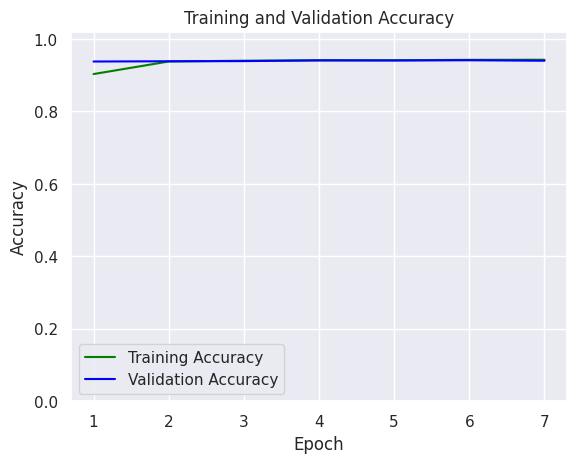

In [61]:
#accuracy plot
import matplotlib.pyplot as plt
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

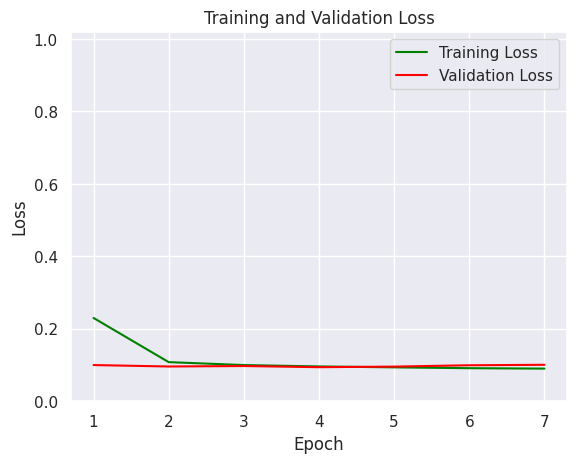

In [62]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

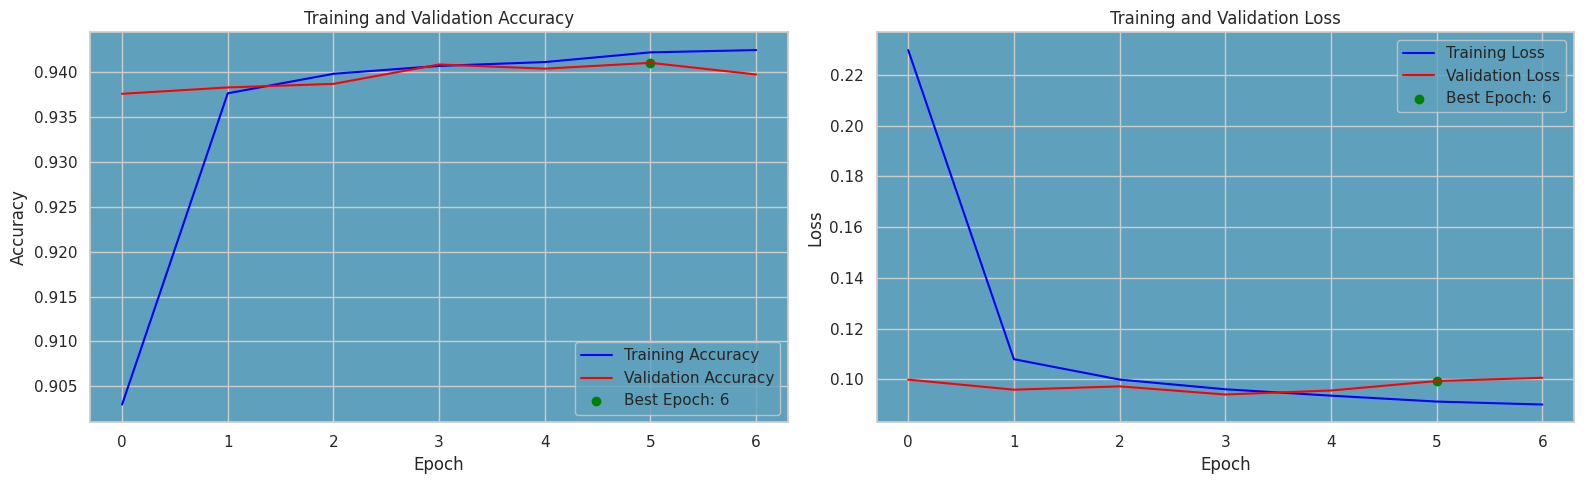

In [41]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [42]:
# Evaluate Test Data 
model.evaluate(X_test_padded, y_test)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9407 - loss: 0.1001


[0.10061392188072205, 0.939729630947113]

In [43]:
# Predictions On Test For Confustion Matrix 
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


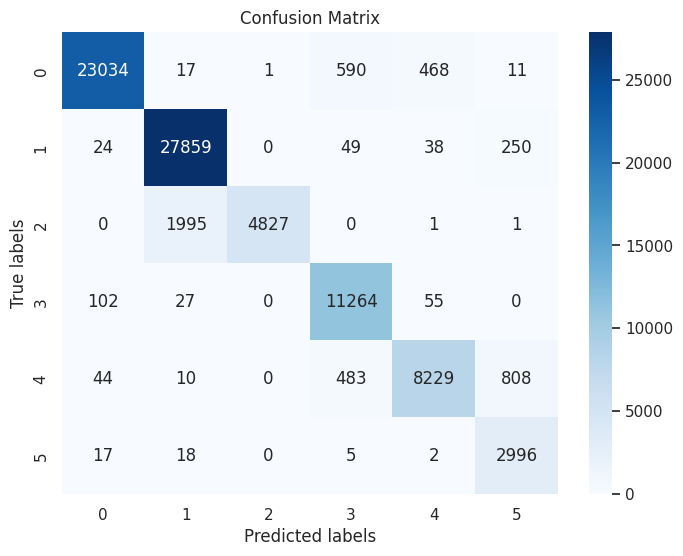

In [44]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()